In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import poisson
import networkx as nx 

#pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.family'] = 'sans-serif'
# Increase pandas width
#pd.set_option('display.width', 400)
# Inline plots yay
%matplotlib inline

In [3]:
words_file = 'words.csv'
words_raw_data = pd.read_csv(words_file)

In [4]:
just_words = words_raw_data[words_raw_data.columns[5:]]
just_words = just_words.fillna(0)

## Extract Cooccurrences

In [5]:
def get_words(row):
    """Returns the list of the marked words in the given row"""
    return [ just_words.columns[ind] for ind, val in enumerate(row) if val > 0 ]

In [6]:
get_words(just_words.values[2])

['Thoughtful', 'Calm', 'Beautiful', 'Talented']

In [7]:
cooccs = {} # words and their co-occurrences
frequencies = {} # general frequencies of the words
NS = just_words.values.size # number of scentences !! CHECK IT
for row in just_words.values:
    words = get_words(row)
    
    for word in words:
        # Check if the word has occured already and count
        # its frequencies
        try: 
            cooccs[word]
            frequencies[word] = frequencies[word] + 1
        except KeyError:
            cooccs[word] = {}
            frequencies[word] = 1
            
        for coocc in words:
            # count the co-occurrence with the current word
            if coocc != word:     
                try:
                    cooccs[word][coocc] = cooccs[word][coocc] + 1
                except KeyError:
                    cooccs[word][coocc] = 1
                    

In [8]:
MAXFREQ = 0
for curTerm in cooccs.keys():
    if frequencies[curTerm] > MAXFREQ:
        MAXFREQ = frequencies[curTerm]

## Significances functions

In [9]:
def n_log_n(n):
    if n <= 0 :
        return 0
    return n * np.log(n)

In [10]:
# calculates the actual significance of the co-occurrences...
# INFO: var 'NS' from above 
def sig_ll(nab, na, nb):
    sig = n_log_n(nab) - n_log_n(na) - n_log_n(nb) + n_log_n(NS) \
        + n_log_n(NS - nb - na + nab) \
        + n_log_n(na - nab) + n_log_n(nb - nab) \
        - n_log_n(NS - na) - n_log_n(NS - nb)
    if (NS * nab) > (na * nb):
        return sig
    return 0.0

In [11]:
def sig_dice(nab, na, nb):
    h_nab = nb if nb <= na else na
    if nab >= h_nab:
        nab = h_nab
    return (2.0 * nab) / (na + nb)

In [12]:
def sig_poisson(nab, na, nb):
    mu = (float(na) * nb) / NS
    return (-1) * poisson.logpmf(nab, mu)

In [13]:
# INFO: var 'MAXFREQ' from above 
def sig_assoc(nab, na, b):
    h_nab = nb if nb <= na else na
    if nab >= h_nab:
        nab = h_nab

    helpfrequa = float(na) / MAXFREQ
    siga = float(nab) / na

    helpfrequb = float(nb) / MAXFREQ
    sigb = float(nab) / nb

    sign = float(0)
    if (na > 1) or (nb > 1):
        if siga >= sigb:
            sign = (float(nab) / na) * helpfrequa
            
    return sign

In [14]:
na = frequencies['Colourful']
nb = frequencies['Background']
nab = cooccs['Colourful']['Background']
sig_poisson(nab, na, nb)

911.77361827408731

## Generate graph

In [15]:
def get_graph(f_sign):
    G = nx.DiGraph()
    G.add_nodes_from(cooccs.keys())
    for curTerm, curCooccs in cooccs.iteritems():
        freq_term_a = frequencies[curTerm]        
        for curCoocc, freq_term_ab in curCooccs.iteritems():
            freq_term_b = frequencies[curCoocc]
            sign = f_sign(freq_term_ab, freq_term_a, freq_term_b)
            G.add_edge(curTerm, curCoocc, weight=sign)
    return G

## Calculate PageRanks

In [16]:
import operator
G_poisson = get_graph(sig_poisson)
G_ll = get_graph(sig_ll)
G_dice = get_graph(sig_dice)

In [23]:
pr_poisson = nx.pagerank_numpy(get_graph(sig_poisson), alpha=0.05)
pr_poisson = sorted(pr_poisson.items(), key=operator.itemgetter(1), reverse=True)

pr_ll = nx.pagerank_numpy(get_graph(sig_ll), alpha=0.05)
pr_ll = sorted(pr_ll.items(), key=operator.itemgetter(1), reverse=True)

pr_dice = nx.pagerank_numpy(get_graph(sig_dice), alpha=0.05)
pr_dice = sorted(pr_dice.items(), key=operator.itemgetter(1), reverse=True)

In [24]:
pr_poisson

[('Distinctive', 0.013272382148571779),
 ('Talented', 0.013166838423626197),
 ('Catchy', 0.013013946809658212),
 ('Original', 0.012914927244141517),
 ('Cool', 0.012898501086706133),
 ('Authentic', 0.01281955189261803),
 ('Current', 0.01279869490163636),
 ('Energetic', 0.012719115837097103),
 ('Beautiful', 0.012714859069263921),
 ('Credible', 0.012641857110708017),
 ('Timeless', 0.012635080472776318),
 ('Stylish', 0.012611889550955173),
 ('Passionate', 0.012592880551961684),
 ('Thoughtful', 0.012569207189601712),
 ('Classic', 0.01256695822768946),
 ('Fun', 0.012530471066897215),
 ('Boring', 0.012517666895462812),
 ('Unoriginal', 0.012508873004073195),
 ('Warm', 0.012499072893179078),
 ('Confident', 0.01248130674900433),
 ('Edgy', 0.012454018961241929),
 ('Free', 0.012451328229229598),
 ('Good lyrics', 0.012445844688715828),
 ('Approachable', 0.012437293813929247),
 ('Upbeat', 0.012414634181492254),
 ('Unattractive', 0.012405818425425154),
 ('Good Lyrics', 0.012400943128882236),
 ('Youth

## Calculate HITS

In [119]:
import operator
G_assoc = get_graph(sig_assoc)

In [132]:
hubs, authorities = nx.hits(G_assoc)
hubs = sorted(hubs.items(), key=operator.itemgetter(1), reverse=True)
authorities = sorted(authorities.items(), key=operator.itemgetter(1), reverse=True)

## Combine them with the mean

In [146]:
dict_p = dict((x, y) for x, y in pr_poisson)
dict_l = dict((x, y) for x, y in pr_ll)
dict_d = dict((x, y) for x, y in pr_dice)
dict_a = dict((x, y) for x, y in authorities)

In [155]:
combines = {}
for term in cooccs.keys():
    s = (dict_p[term] + dict_l[term] + dict_d[term] + dict_a[term]) / 4
    combines[term] = s

In [158]:
sorted(combines.items(), key=operator.itemgetter(1), reverse=True)

[('Distinctive', 0.020537092588989742),
 ('Talented', 0.01961324733238577),
 ('Original', 0.017716415716561188),
 ('Cool', 0.017488920129503163),
 ('Free', 0.017464456020722725),
 ('Authentic', 0.017404108457903064),
 ('Good Lyrics', 0.017352995156741942),
 ('Catchy', 0.017161942730958772),
 ('Current', 0.01652955522327245),
 ('Beautiful', 0.016522639447826164),
 ('Credible', 0.016300000625761507),
 ('Stylish', 0.01628892429845479),
 ('Timeless', 0.01626767275987494),
 ('Energetic', 0.01598660978391591),
 ('Passionate', 0.0158934924581073),
 ('Thoughtful', 0.015668062414962783),
 ('Classic', 0.01562917966818016),
 ('Fun', 0.015103287541074768),
 ('Emotional', 0.01471241638987052),
 ('Warm', 0.014668325884819363),
 ('Edgy', 0.01466188272536748),
 ('Approachable', 0.014632640078362614),
 ('Colourful', 0.014546657192934319),
 ('Exciting', 0.014336711746479483),
 ('Popular', 0.014275581950441148),
 ('Upbeat', 0.014050808353947541),
 ('Uplifting', 0.01385340767019225),
 ('Heartfelt', 0.0138

In [159]:
print(nx.square_clustering(G_assoc))

{'Superficial': 1.0, 'Wholesome': 1.0, 'Cool': 0.18465231662011117, 'Catchy': 0.22865606688623072, 'Distinctive': 0.18465231662011117, 'Serious': 1.0, 'Outspoken': 0.6742177170559718, 'Unoriginal': 1.0, 'Laid back': 0.6742177170559718, 'Nostalgic': 1.0, 'Current': 0.18465231662011117, 'Confident': 1.0, 'Unapproachable': 1.0, 'Calm': 1.0, 'Stylish': 0.18465231662011117, 'Upbeat': 0.22865606688623072, 'Way out': 0.6742177170559718, 'Intrusive': 1.0, 'Uplifting': 0.6742177170559718, 'Relaxed': 0.6742177170559718, 'Approachable': 0.18465231662011117, 'Good lyrics': 1.0, 'Relatable': 1.0, 'Mainstream': 1.0, 'Inspiring': 1.0, 'Iconic': 1.0, 'Free': 0.6742177170559718, 'Sophisticated': 0.6742177170559718, 'Depressing': 1.0, 'Warm': 0.18465231662011117, 'Uninspired': 1.0, 'Background': 0.6742177170559718, 'Sexy': 0.18465231662011117, 'Exciting': 0.6742177170559718, 'Irrelevant': 1.0, 'Soulful': 0.7059186951686642, 'Sociable': 0.6742177170559718, 'Not authentic': 1.0, 'Credible': 0.184652316620

In [43]:
nx.draw_networkx?

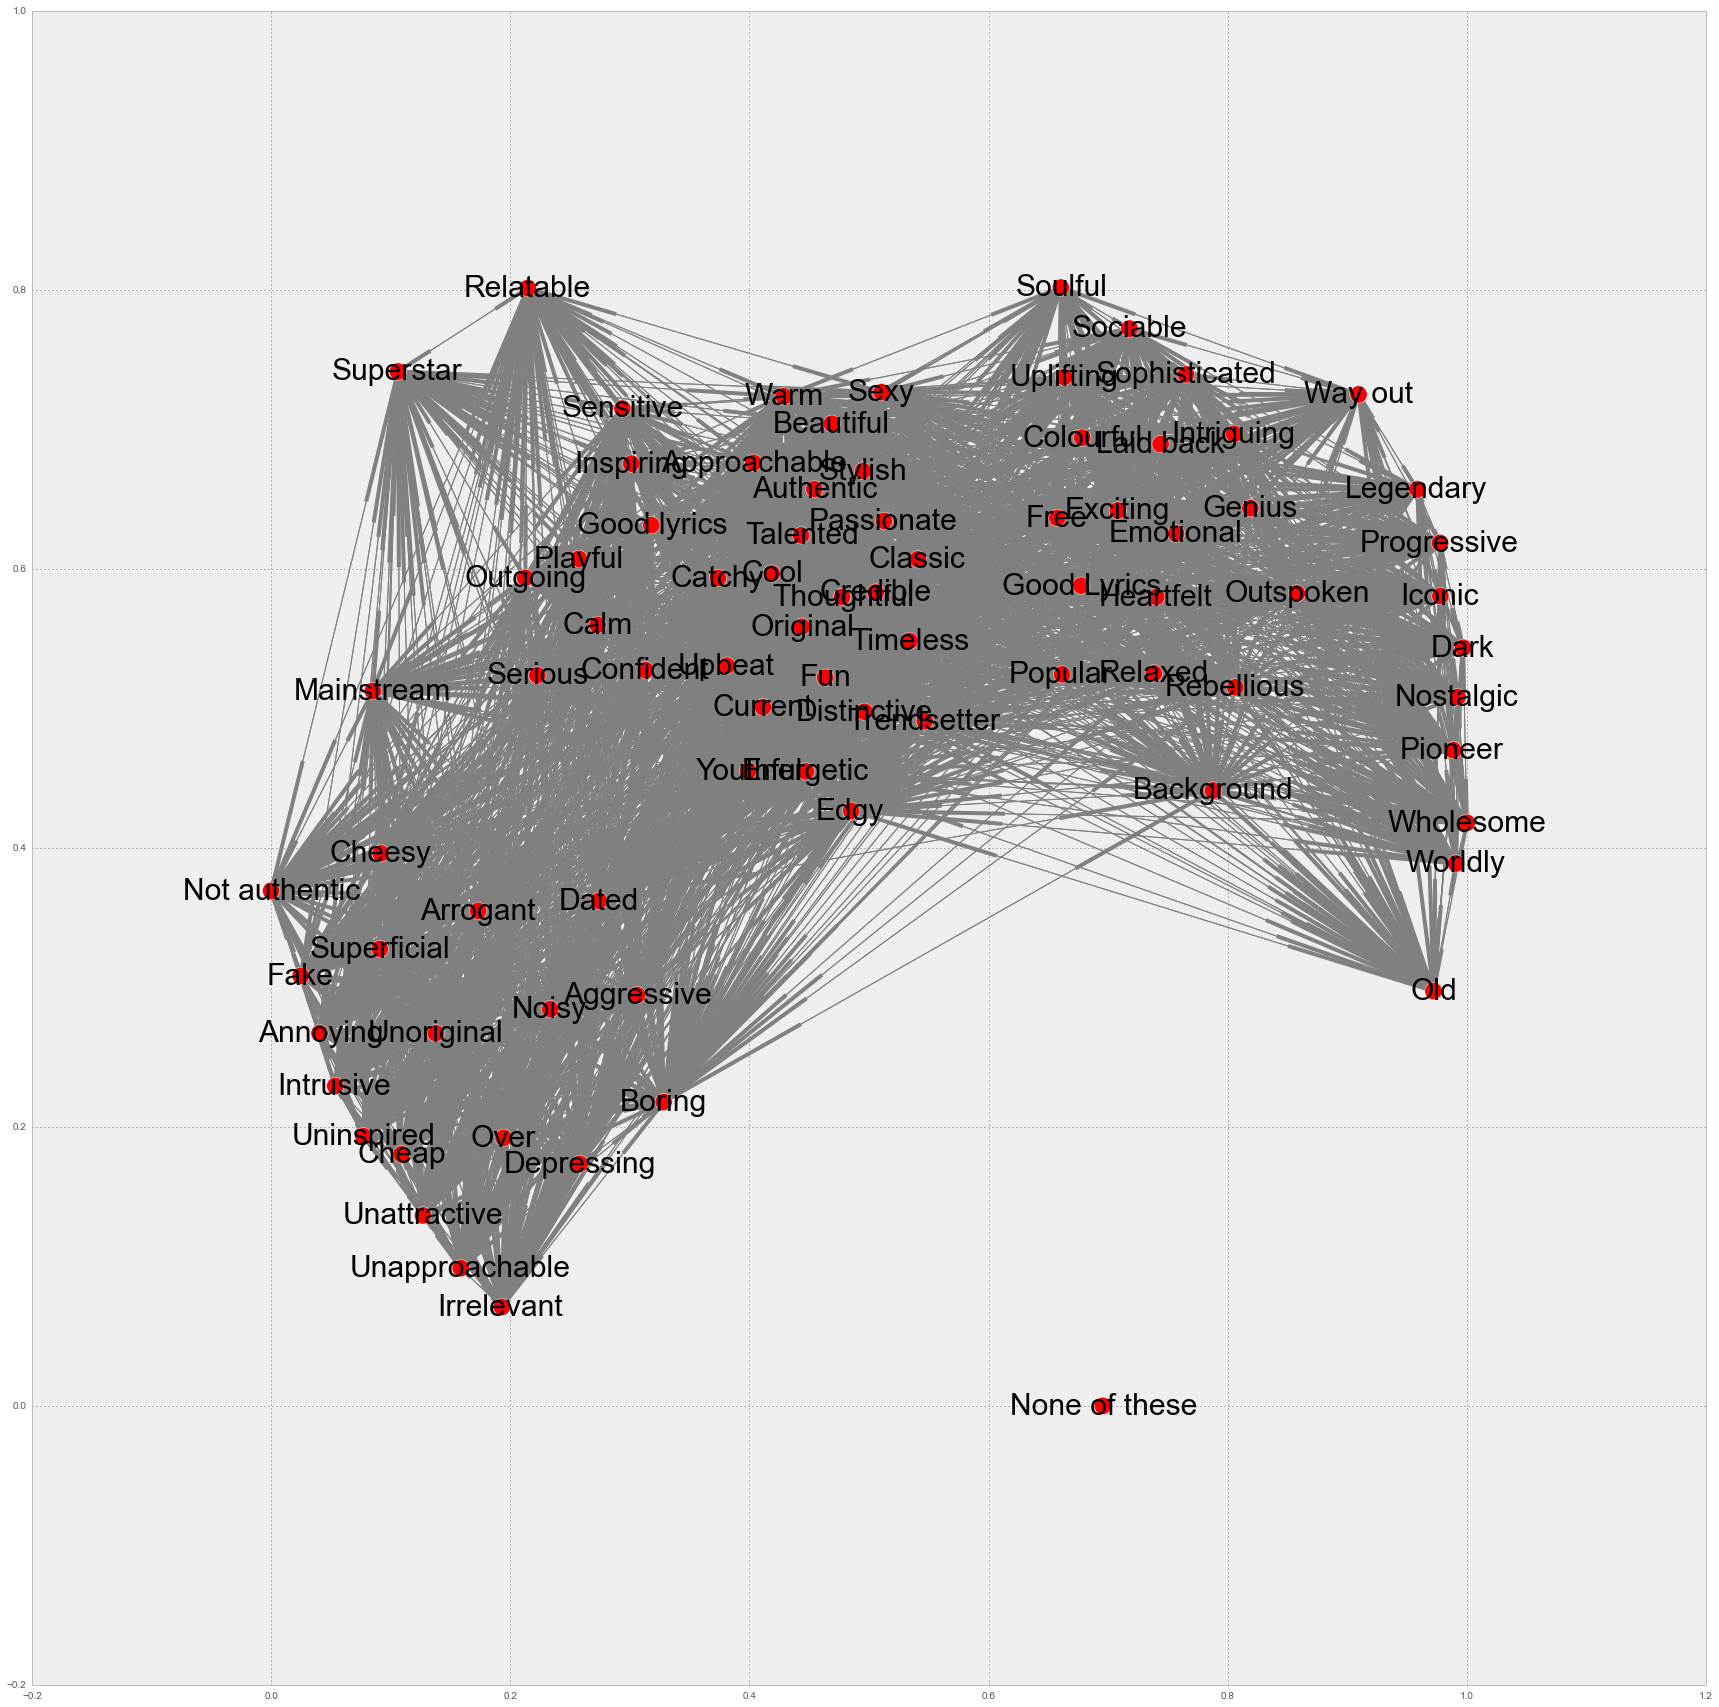

In [44]:
plt.rcParams['figure.figsize'] = (30, 30)
nx.draw_networkx(G_dice, font_size=30, edge_color='gray')